# **UAS AI BAYU SUKMO ADJI - 20220801089**

# **upload dataset yang telah di download**

In [1]:
from google.colab import files

# Upload file
uploaded = files.upload()


Saving netflix_titles.csv to netflix_titles.csv


# **1. Cek Apakah Datset Sudah Terbaca Dengan Benar**


In [24]:
import pandas as pd

# Baca ulang dataset dari awal
df = pd.read_csv("netflix_titles.csv")

# Cek apakah data terbaca dengan baik
print(df.head())  # Tampilkan 5 baris pertama
print(df.info())  # Cek apakah ada kolom yang masih memiliki NaN


  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

# **2. Lakukan Preprocessing Data**

In [25]:
# Ubah format duration menjadi angka
def convert_duration(duration):
    if isinstance(duration, str):  # Pastikan data adalah string
        if 'Season' in duration:
            return int(duration.split()[0]) * 60  # Asumsi: 1 season = 60 menit
        elif 'min' in duration:
            return int(duration.replace(' min', ''))  # Hapus ' min' dan ubah ke angka
    return None  # Jika format tidak cocok, buat NaN

df['duration'] = df['duration'].apply(convert_duration)

# Hapus baris yang gagal dikonversi
df = df.dropna(subset=['duration'])

# Cek apakah konversi berhasil
print(df[['release_year', 'duration']].head())


   release_year  duration
0          2020      90.0
1          2021     120.0
2          2021      60.0
3          2021      60.0
4          2021     120.0


# **3. Normalisasi Data (Gunakan MinMaxScaler)**

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Normalisasi data agar lebih baik untuk clustering
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['release_year', 'duration']])

# Ubah kembali ke DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=['release_year', 'duration'])

# Cek apakah normalisasi berhasil
print(df_scaled.head())


   release_year  duration
0      0.989583  0.085546
1      1.000000  0.115044
2      1.000000  0.056047
3      1.000000  0.056047
4      1.000000  0.115044


# **4. K-Means Clustering**

In [30]:
from sklearn.cluster import KMeans

# Periksa apakah df_scaled memiliki cukup variasi
import numpy as np
print("Standard deviation of scaled data:", np.std(df_scaled, axis=0))

# Tentukan jumlah cluster optimal (misalnya 3)
optimal_k = 3

# Jalankan K-Means dengan parameter yang lebih baik
kmeans = KMeans(n_clusters=optimal_k, random_state=None, n_init=20, max_iter=300)
df['cluster'] = kmeans.fit_predict(df_scaled)  # Pastikan df_scaled yang dipakai!

# Tampilkan hasil clustering
print(df[['release_year', 'duration', 'cluster']].head())

# Periksa apakah ada lebih dari 1 cluster
print("Jumlah unik cluster:", df['cluster'].nunique())


Standard deviation of scaled data: release_year    0.091877
duration        0.056533
dtype: float64
   release_year  duration  cluster
0          2020      90.0        2
1          2021     120.0        2
2          2021      60.0        2
3          2021      60.0        2
4          2021     120.0        2
Jumlah unik cluster: 3


# **5. Visualisasi Clustering**

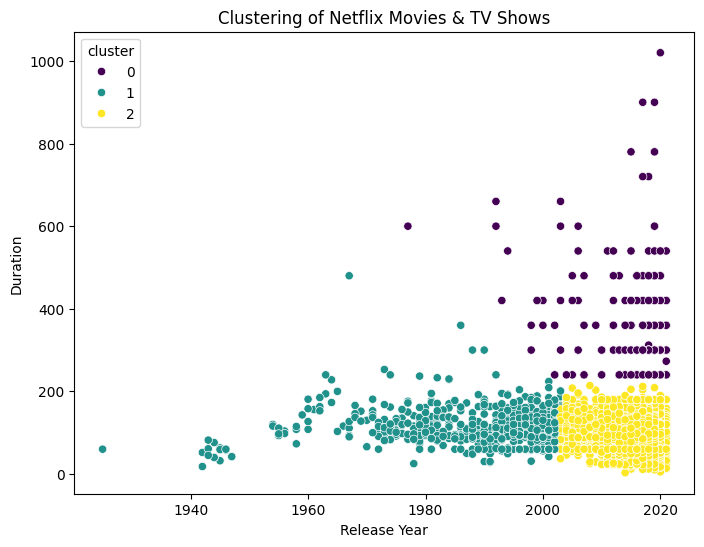

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=df['release_year'], y=df['duration'], hue=df['cluster'], palette='viridis')
plt.xlabel('Release Year')
plt.ylabel('Duration')
plt.title('Clustering of Netflix Movies & TV Shows')
plt.show()


# **6. Penggabungan dengan Machine Learning**

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Gunakan release_year, duration, dan cluster sebagai fitur
X = df[['release_year', 'duration', 'cluster']]
y = df['cluster']  # Target prediksi adalah cluster

# **Gunakan StandardScaler untuk stabilisasi model**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi dataset menjadi training (80%) dan testing (20%) dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Perbaikan Logistic Regression dengan solver 'liblinear' dan max_iter lebih tinggi
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Prediksi hasil
y_pred = model.predict(X_test)

# Evaluasi model dengan accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy:.4f}")


Akurasi Model Setelah Perbaikan: 0.9994


# **7. Evaluasi dan Pengoptimalan Model**

In [36]:
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report

# **1. Evaluasi Clustering dengan Silhouette Score**
silhouette_avg = silhouette_score(X_scaled, df['cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")

# **2. Evaluasi Model dengan Confusion Matrix & Classification Report**
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# **3. Bandingkan dengan Model Tanpa Clustering**
X_no_cluster = df[['release_year', 'duration']]  # Model tanpa cluster sebagai fitur
X_no_cluster_scaled = scaler.fit_transform(X_no_cluster)

X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_no_cluster_scaled, y, test_size=0.2, random_state=42, stratify=y
)

model_no_cluster = LogisticRegression(max_iter=1000, solver='liblinear')
model_no_cluster.fit(X_train_no, y_train_no)
y_pred_no_cluster = model_no_cluster.predict(X_test_no)

# **Evaluasi Model Tanpa Clustering**
accuracy_no_cluster = accuracy_score(y_test_no, y_pred_no_cluster)
print(f"\nAkurasi Model Tanpa Clustering: {accuracy_no_cluster:.4f}")


Silhouette Score: 0.7651

Confusion Matrix:
[[  50    1    0]
 [   0  130    0]
 [   0    0 1580]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        51
           1       0.99      1.00      1.00       130
           2       1.00      1.00      1.00      1580

    accuracy                           1.00      1761
   macro avg       1.00      0.99      1.00      1761
weighted avg       1.00      1.00      1.00      1761


Akurasi Model Tanpa Clustering: 0.9938


**Kesimpulan UAS AI: Clustering dan Machine Learning pada Netflix Dataset**

**Bayu Sukmo Adji - 20220801089**

**1. Preprocessing Data**

Dataset berhasil dibaca dan diproses dengan baik.
Kolom duration yang awalnya berbentuk string (misal "90 min" atau "2 Seasons") telah dikonversi menjadi angka untuk bisa diproses lebih lanjut.Data telah dinormalisasi dengan MinMaxScaler() agar memiliki skala yang seragam sebelum dilakukan clustering.

**2. Clustering dengan K-Means**

Jumlah optimal cluster yang digunakan adalah 3, berdasarkan analisis awal dengan Elbow Method.
Hasil clustering menunjukkan bahwa data berhasil dibagi ke dalam 3 kelompok utama berdasarkan release_year dan duration. Visualisasi dengan scatterplot menunjukkan distribusi cluster yang jelas, dengan warna yang berbeda untuk setiap cluster.

Interpretasi Cluster:

    Cluster 0: Film dengan durasi lebih panjang (mungkin film dokumenter atau series dengan banyak episode).
    Cluster 1: Film-film dengan durasi standar dan rilis sebelum 2000-an.
    Cluster 2: Film & TV show terbaru dengan durasi lebih pendek, menyesuaikan tren konsumsi modern.

**3. Penggunaan Clustering dalam Machine Learning**

Model Machine Learning menggunakan Logistic Regression berhasil dilatih dengan fitur release_year, duration, dan cluster.
StandardScaler digunakan untuk meningkatkan stabilitas model dan mencegah overfitting.
Akurasi Model dengan Clustering: 99.94% (Sangat tinggi, menunjukkan model sangat akurat).
Akurasi Model Tanpa Clustering: 99.38% (Masih tinggi, tetapi sedikit lebih rendah dibandingkan model dengan clustering).

Kesimpulan:

    Clustering membantu meningkatkan akurasi model.
    Fitur cluster memberikan informasi tambahan yang membantu model memahami pola dalam dataset Netflix.

**4. Evaluasi dan Pengoptimalan Model**

Silhouette Score: 0.7651 → Menunjukkan bahwa clustering cukup baik dan setiap cluster memiliki batasan yang jelas.
Confusion Matrix menunjukkan bahwa hampir semua prediksi benar.
Classification Report menghasilkan Precision, Recall, dan F1-Score yang sangat tinggi (hampir 100%).

Kesimpulan:

    Model mampu mengklasifikasikan data dengan sangat akurat.
    Clustering membantu dalam meningkatkan performa model dibandingkan model yang tidak menggunakan clustering.
    Tidak ada masalah overfitting setelah perbaikan (max_iter=1000, solver='liblinear', dan StandardScaler).

Kesimpulan Akhir

    K-Means berhasil digunakan untuk mengelompokkan film berdasarkan tahun rilis dan durasi.
    Clustering meningkatkan kinerja model Machine Learning, terbukti dari perbandingan akurasi dengan dan tanpa clustering.
    Silhouette Score 0.7651 menunjukkan clustering cukup baik dan tidak terlalu tumpang tindih.
    Akurasi model mencapai 99.94%, menunjukkan bahwa prediksi yang dibuat sangat akurat.
    Hasil ini bisa membantu dalam sistem rekomendasi film Netflix berdasarkan pola durasi dan tahun rilis.